# Infrared Heating/Cooling Rates with PyARTS

**Don't forget the import statements below!**

In [4]:
%matplotlib inline

# Set path to line catalogue
import os
import warnings
warnings.filterwarnings('ignore')

if os.path.isdir('/home/jovyan/esci345/'):
    os.environ["ARTS_DATA_PATH"] = "/share/share/ESCI345/"
    os.environ["ARTS_XML_ATMO"] = "/share/share/esci345/atmospheres/"
else:
    os.environ["ARTS_DATA_PATH"] = "/Users/wgblumbe/Code/rttools/arts_catalogs/arts-cat-data-snapshot-arts-2.5.8/"
    os.environ["ARTS_XML_ATMO"] = "/Users/wgblumbe/Code/rttools/ESCI345/atmospheres/"
    
import matplotlib.pyplot as plt
import numpy as np
import typhon as ty
from pyarts import xml
from heating_rates_module import (calc_spectral_irradiance, calc_irradiance,
                                  integrate_spectral_irradiance)
import pint
import proplot as pplt

ureg = pint.UnitRegistry()
#ty.plots.styles.use("seaborn-talk")
pplt.use_style('seaborn-talk')
pplt.rc["legend.facecolor"] = "white"


# Section 1: Mathematics behind the heating/cooling rates

The heating rate denotes the change of atmospheric temperature with time due
to gain or loss of energy. Here, we consider only the gain or loss due to
radiation.
The heating rate including only radiation is  

$$\frac{\partial T\left(z\right)}{\partial t}=-\frac{1}{\rho\left( z \right) c_p }\frac{\partial}{\partial z}F_{net}\left( z \right)$$

with $\rho\left( z \right)$ the density of dry air (To keep it simple, we assume dry air. 
In reality the air is not dry. Nonetheless, the differences are small.), $c_p = 1.0035\, \text{J}\, \text{kg}^{-1} \text{K}^{-1}$ the specific heat 
capacity of dry air and $F_{net}$ the net radiation flux. 
The net radiation flux is  

$$F_{net}=F_{up}-F_{down}$$

with $F_{up}$ and $F_{down}$ the up- and downward radiation flux (irradiance), respectively. 
The density of dry air is  

$$\rho  =\frac{p}{R_s\,T}$$

with pressure $p$, temperature  $T$ and the specific gas constant 
$R_s = 287.058\, \text{J}\,\text{kg}^{-1} \text{K}^{-1}$.

# Section 2: Calculating broadband fluxes and cooling rates

The following cells require that you load one of the FASCODE atmospheres into PyARTS.  The allowed atmospheres include:
* ``midlatitude-summer``
* ``midlatitude-winter``
* ``tropical``
* ``subarctic-summer``
* ``subarctic-winter``

You may also find it interesting to scale the concentration of different IR absorbing gas species to visualize the radiative impact this has on the longwave fluxes and heating/cooling rates.  Absorbing species included in these simulations are: $\text{CO}_2$, $\text{H}_2\text{O}$, $\text{O}_3$, $\text{CH}_4$, $\text{N}_2\text{O}$, and $\text{CO}$.  A scaling of 1 represents no change in the absorber concentration.

In [49]:
# Read input atmosphere
atmfield = xml.load("input/midlatitude-summer.xml")

# Scale an absorber species "abs_species-CO2" by the value of 1.
atmfield.scale("abs_species-CO2", 1)

## Section 2.1: Broadband Upward and downward longwave radiation fluxes.

Run the next cell. This will calculate the upward and downward longwave radiation fluxes.  
Here, we will consider only the longwave flux.  PyARTS only recently got the ability to do shortwave calculations.

Calculate the net flux and plot upward, downward and net flux together in one figure against altitude. See if you can explain the plot to a partner in our class. 

In [72]:
# Calculate the radiation irradiance (flux)

z, p, T, flux_downward, flux_upward = calc_irradiance(atmfield)

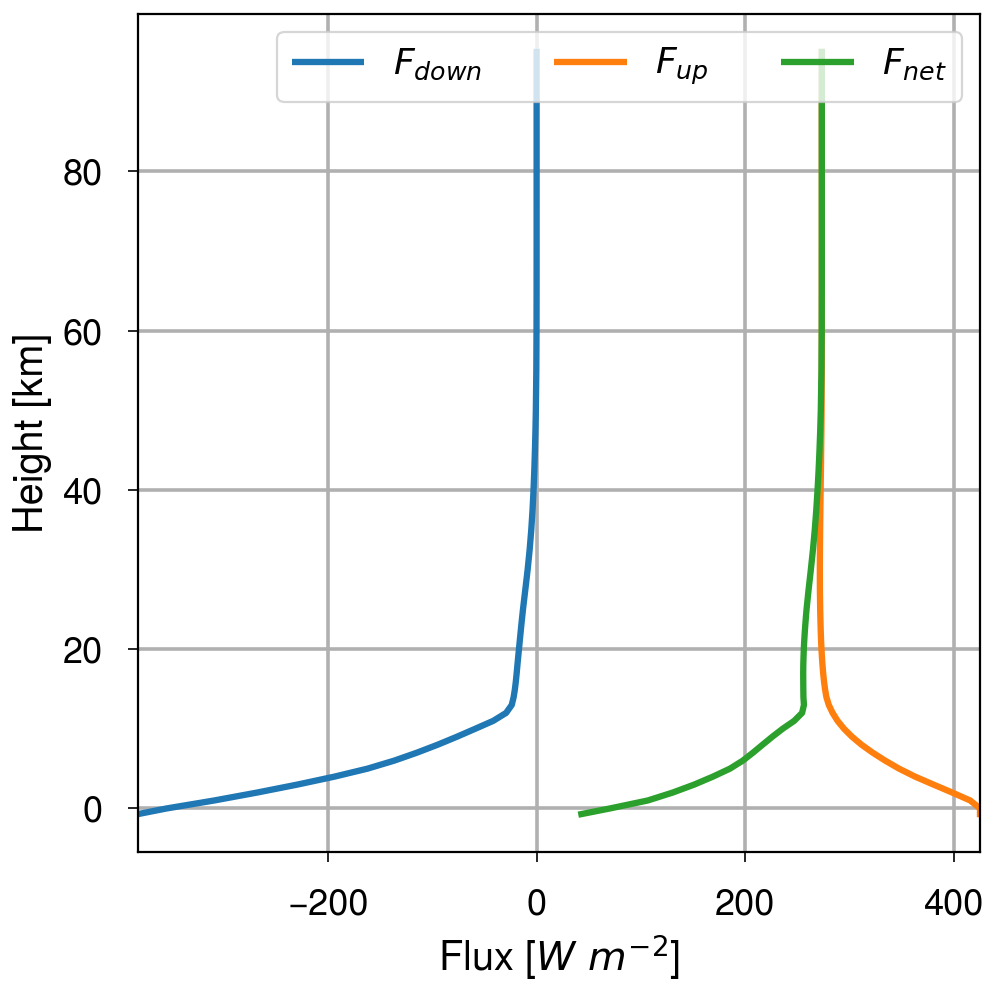

In [102]:
#  Calculate net flux and plot up-, down- and net flux
net_flux = flux_upward - flux_downward

fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(5,5))
axs.plot(-flux_downward, z/1000., label="$F_{down}$")
axs.plot(flux_upward, z/1000., label="$F_{up}$")
axs.plot(net_flux, z/1000., label="$F_{net}$")
axs.legend()
axs.format(grid=True, ylabel="Height [km]", xlabel="Flux [$W\ m^{-2}$]")
pplt.show()

## Section 2.2: Broadband Longwave heating/cooling rates

Below is an implementation of the function to calculate the heating/cooling rates `calc_heatingrates(...)`. 

The cell below it plots the cooling rates with altitude. See if you can explain the following questions to a partner:

* How would a cooling rate in thermal equilibrium (assuming only longwave radiation) look like?  
* Why is the cooling rate so much higher in the stratosphere than in the troposphere?

In [76]:
# Implement heating rate function

def calc_heatingrates(z, p, T, Fnet):
    """Calculate the heating rate.

    Parameters:
        z (ndarray): Altitude [m].
        p (ndarray): Pressure [Pa].
        T (ndarray): Temperature [K].
        Fnet (ndarray): Net flux [W m^-2].

    Returns:
        ndarray, ndarray:
        Heating rate [K/d], Altitude [m].
    """

    Rs = 287.058 # J/kg K
    density = (p/(Rs * T))[np.newaxis,...] # Should use the virtual temperature correction here...
    Cp = 1003.5 # J/kg/K
    #print(density)
    grad_flux = np.gradient(Fnet, z, axis=0)
    #print(grad_flux.shape, density.shape)
    if grad_flux.ndim != 1:
        heating_rate = grad_flux * (1./(density * Cp)).T
    else:
        heating_rate = grad_flux * (1./(density * Cp).squeeze()).T

    
    return heating_rate*3600*24, z

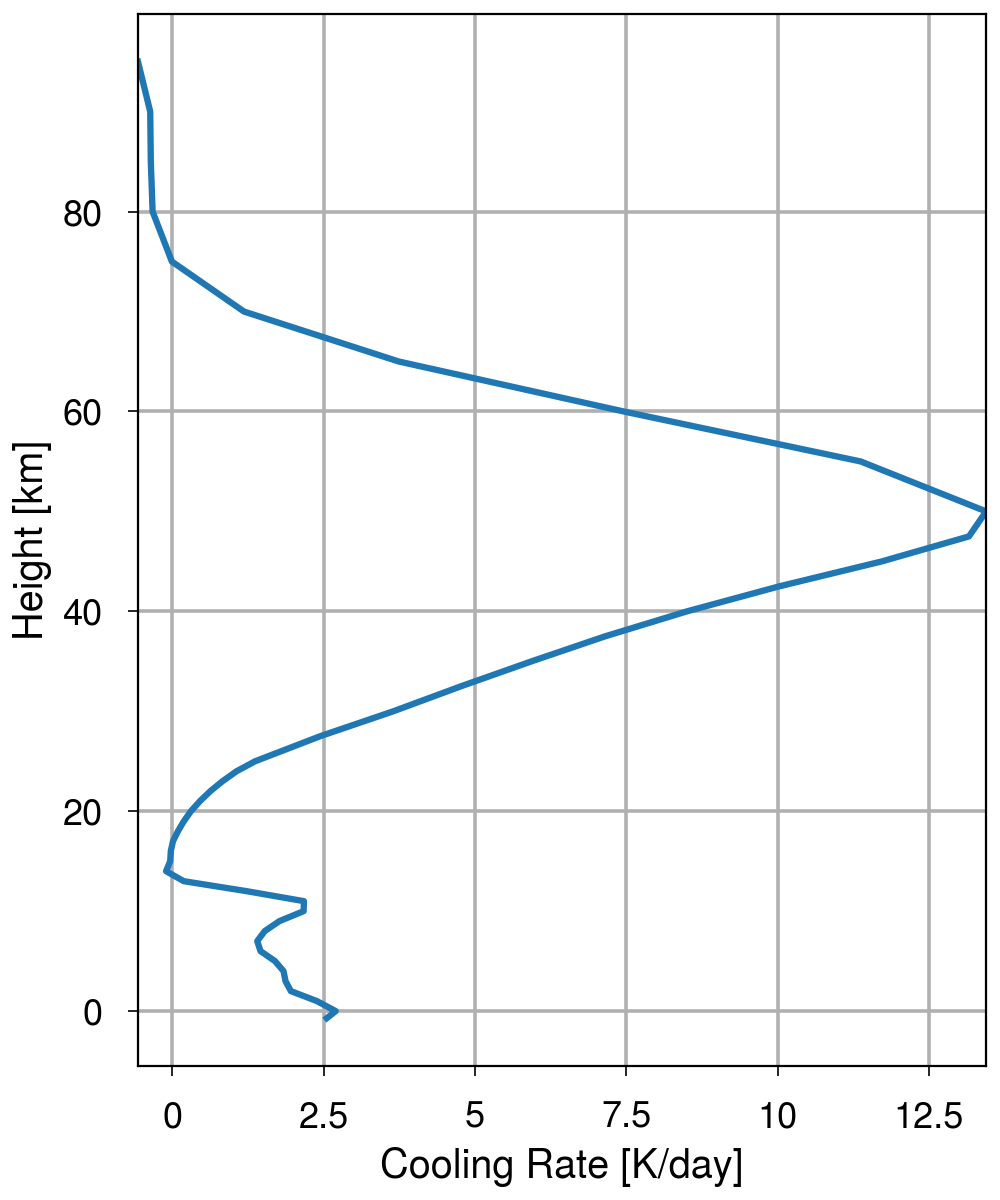

In [104]:
# Calculate heating rate and plot it
net_flux = flux_upward - flux_downward
total_heating,zp_lay = calc_heatingrates(z, p, T, net_flux)
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(5,6))
axs.plot(total_heating.squeeze(), z/1000.)
axs.format(grid=True, ylabel="Height [km]", xlabel="Cooling Rate [K/day]")
pplt.show()

## Section 2.3: Spectral upward and downward longwave fluxes

Calculate the spectral upward, downward and net flux using the function `calc_spectral_irradiance`.  With a partner, explain why variations in upwelling and downwelling fluxes occur in each spectral region.

In [54]:
# Calculate the spectral irradiance (spectral flux)
f, z, p, T, spectral_flux_downward, spectral_flux_upward = calc_spectral_irradiance( atmfield, fnum=1_000, nstreams=2, verbosity=1)
spectral_flux_downward = spectral_flux_downward*(3e8) # convert from W/(m2 Hz) to W/(m2 * m-1)
spectral_flux_upward = spectral_flux_upward*(3e8) # convert from W/(m2 Hz) to W/(m2 * m-1)


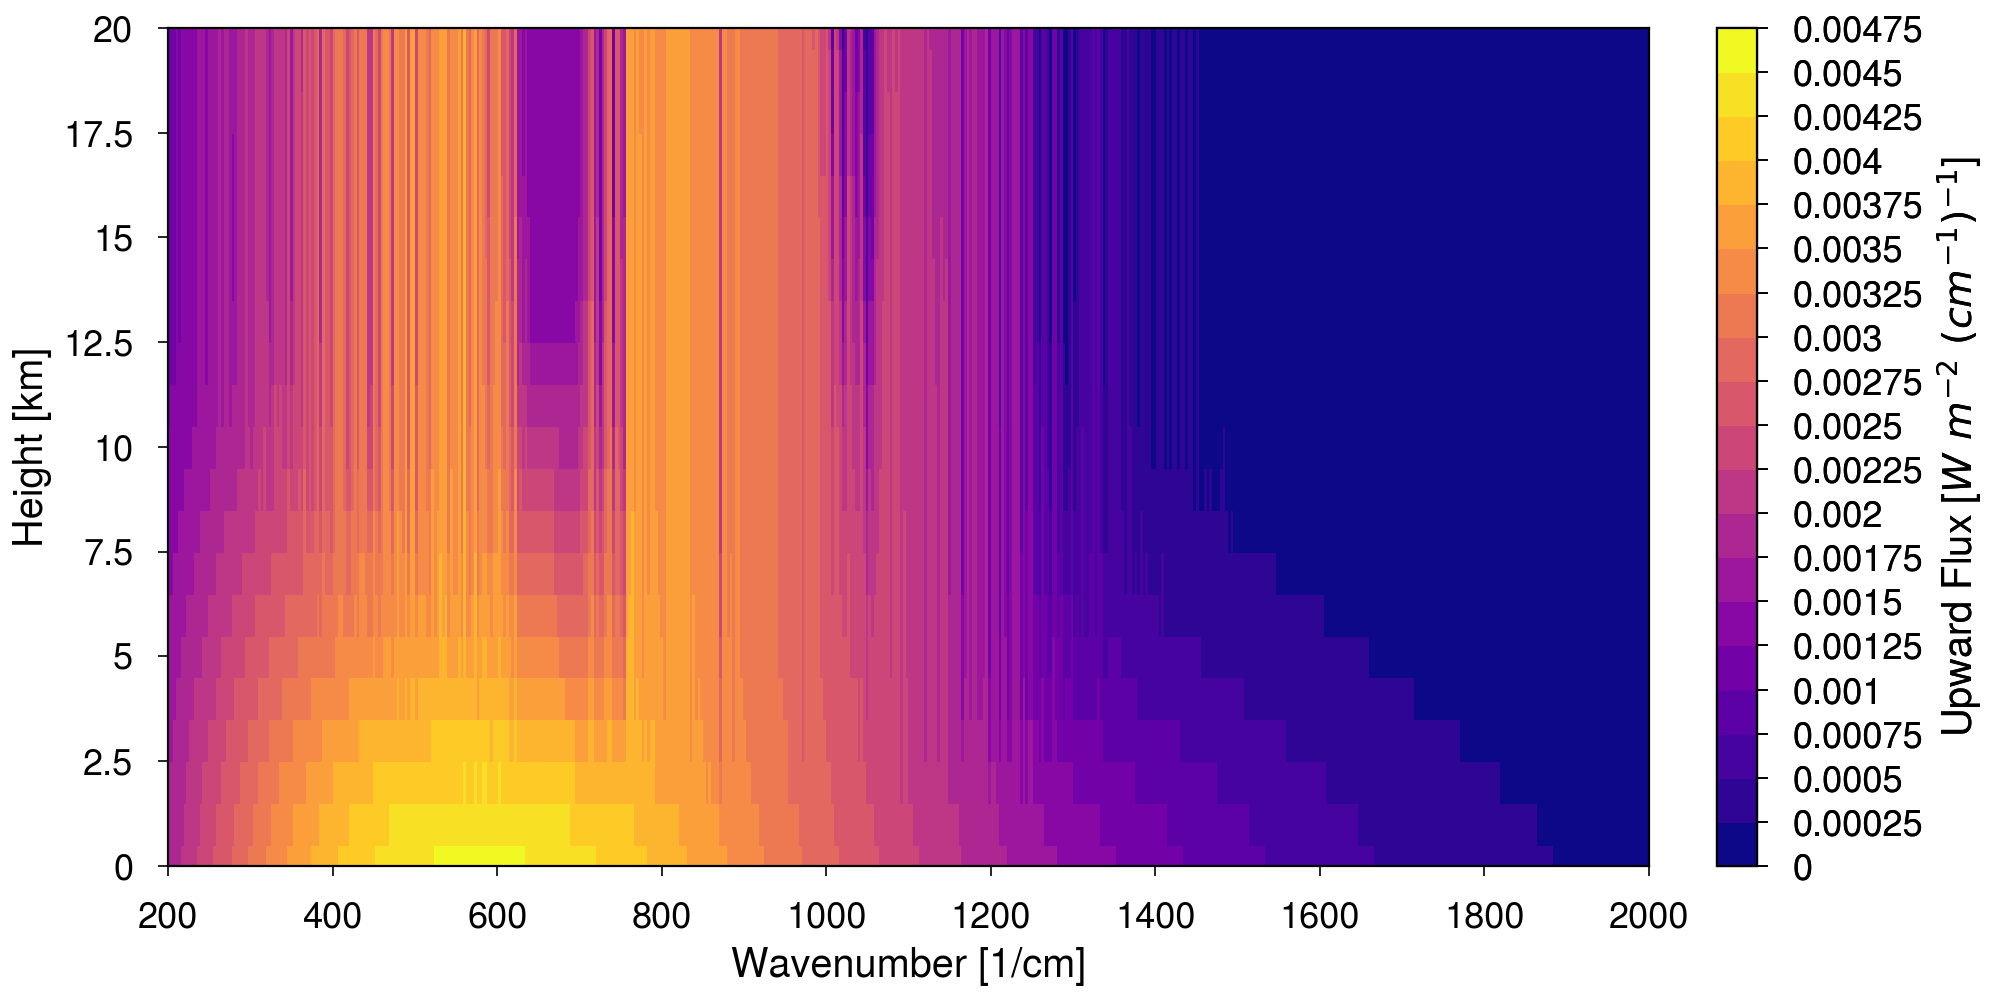

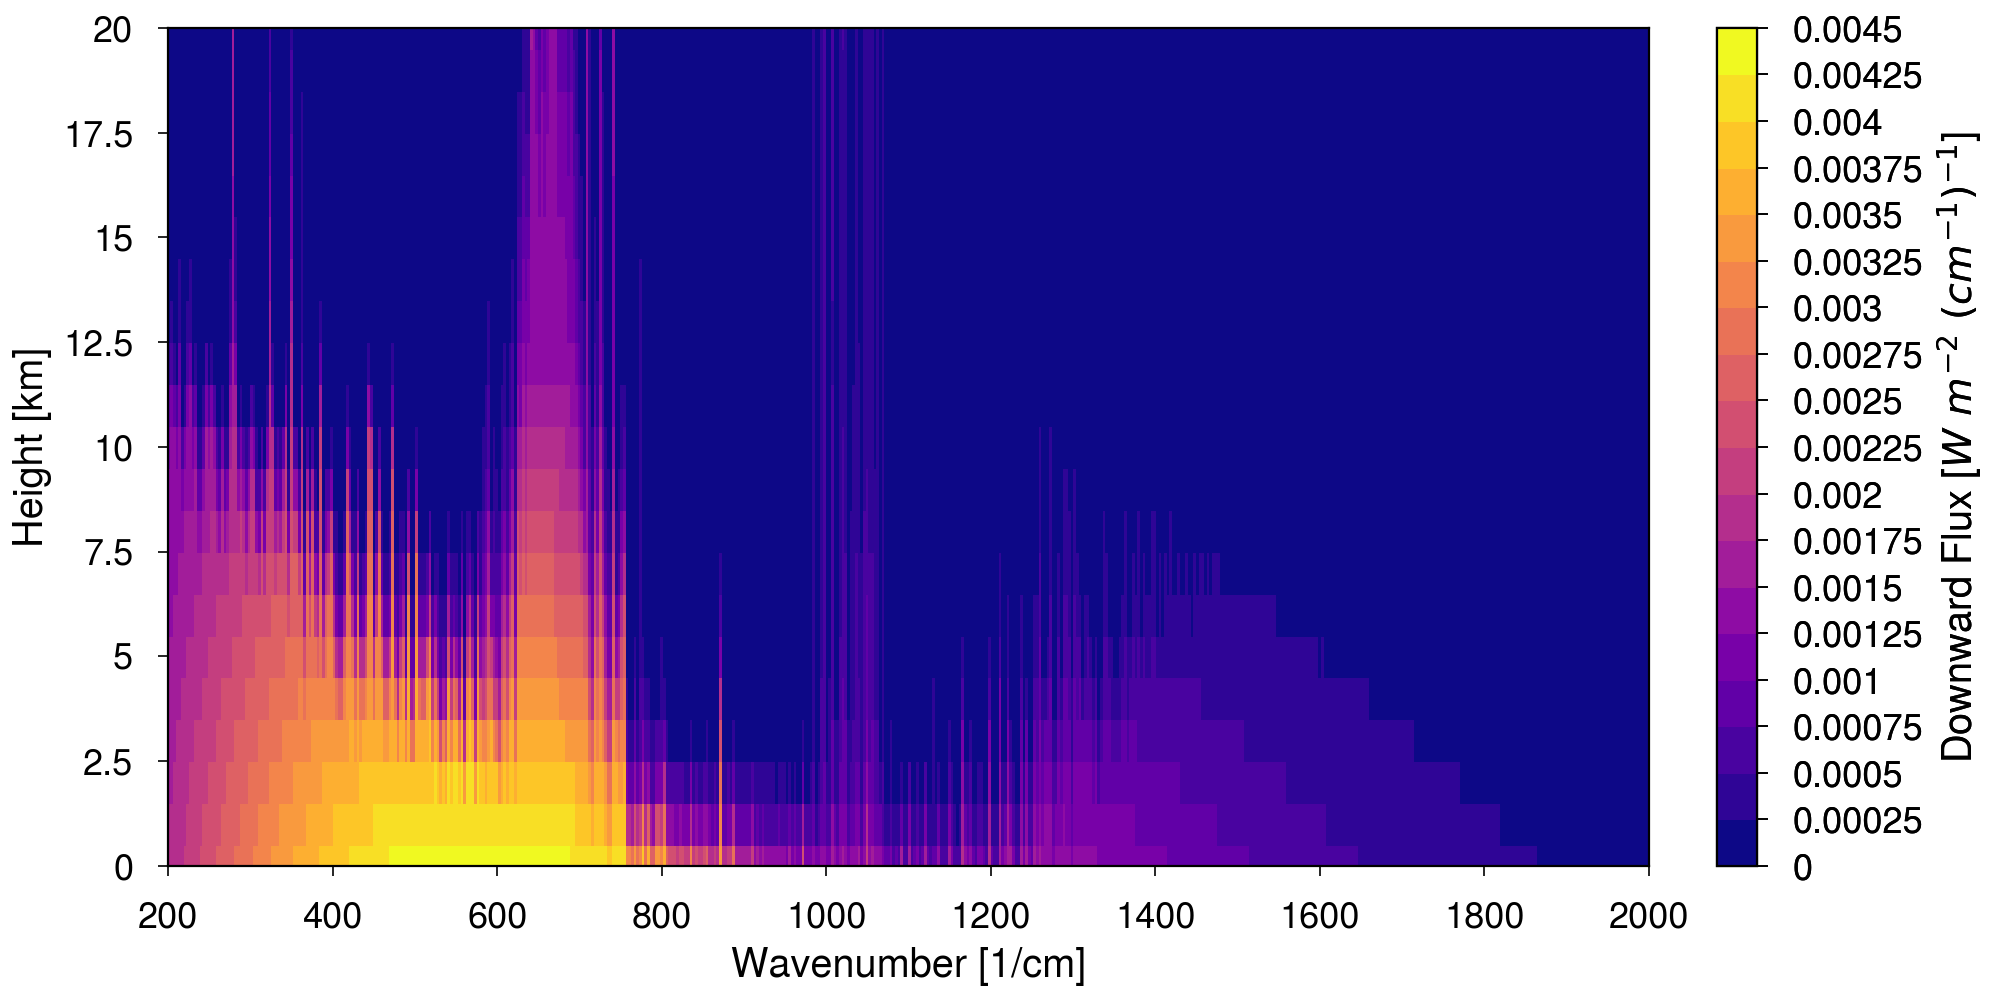

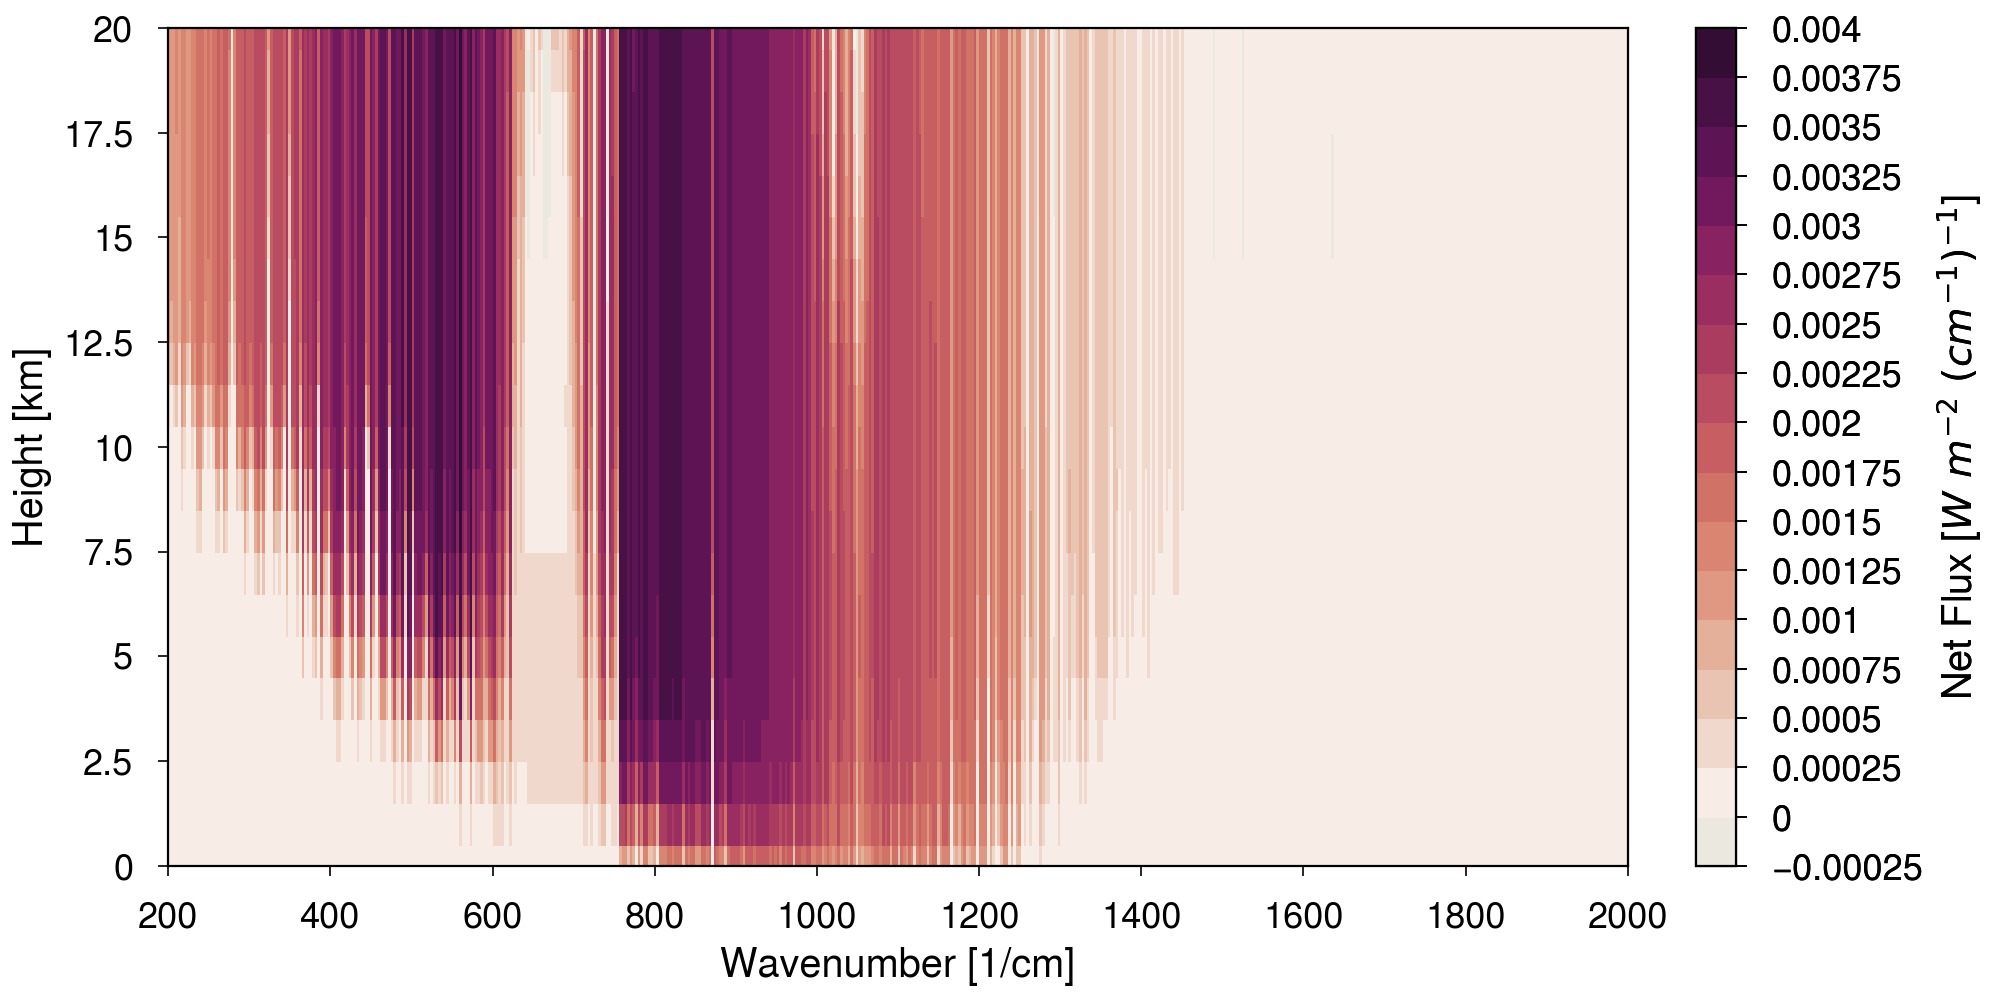

In [97]:
# Convert to wavenumber space 
funit = f * ureg.Hz
wnum = funit.to('1/cm', 'spectroscopy')

fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(3,20), ylim=(0,20), ylabel="Height [km]", xlabel="Wavelength [µm]")
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [1/cm]")

c = ax.pcolormesh(wnum.magnitude, z/1000., (spectral_flux_upward).T, cmap='plasma', levels=20)
#cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ m^{-1}$]')
cb = fig.colorbar(c, label=r'Upward Flux [$W\ m^{-2}\ (cm^{-1})^{-1}$]')

pplt.show()


fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(3,20), ylim=(0,20), ylabel="Height [km]", xlabel="Wavelength [µm]")
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [1/cm]")

c = ax.pcolormesh(wnum.magnitude, z/1000., (spectral_flux_downward).T, cmap='plasma', levels=20)
#cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ m^{-1}$]')
cb = fig.colorbar(c, label='Downward Flux [$W\ m^{-2}\ (cm^{-1})^{-1}$]')

pplt.show()


fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(3,20), ylim=(0,20), ylabel="Height [km]", xlabel="Wavelength [µm]")
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [1/cm]")

c = ax.pcolormesh(wnum.magnitude, z/1000., (spectral_flux_upward - spectral_flux_downward).T, cmap='curl', levels=20, diverging=True)
#cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ m^{-1}$]')
cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ (cm^{-1})^{-1}$]')

pplt.show()

## Section 2.4: Spectral cooling rates

Using the plots, explain the following with a partner:

* How would a ***spectral*** cooling rate in thermal equilibrium (assuming only longwave radiation) look like?  
* Why is does the cooling rate vary so much between different heights?

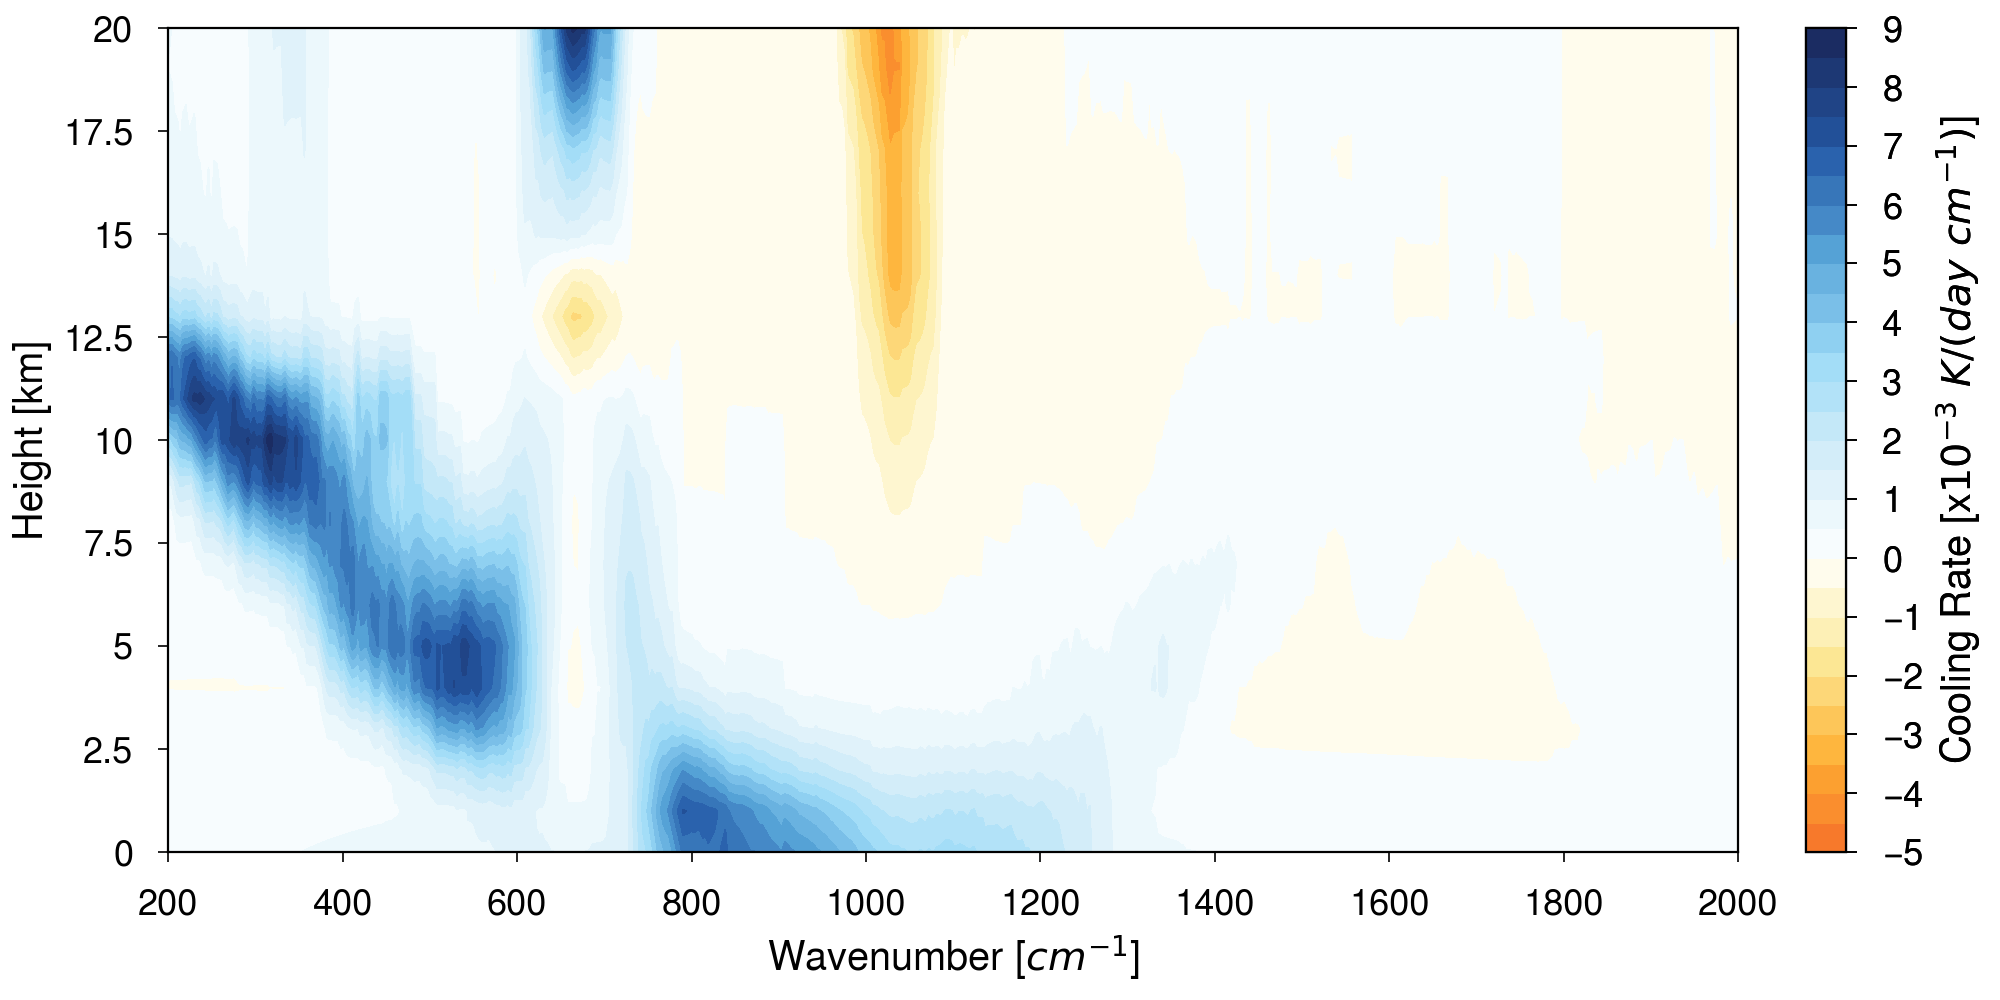

In [62]:
net_flux = (spectral_flux_upward - spectral_flux_downward).T
HR,zp_lay = calc_heatingrates(z, p, T, net_flux)

# Smooth the spectral heating rates (they get kinda noisy)
smoothed_HR = np.ones(HR.shape)
for i, layer in enumerate(HR):
    N = 20
    smoothed_HR[i,:] = np.convolve(layer, np.ones(N)/N, mode='same')

fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [$cm^{-1}$]")

levels = 30
c= ax.contourf(wnum.magnitude, z/1000., smoothed_HR*100.*1e3, levels=levels, cmap="ColdHot_r")
cb = fig.colorbar(c, label='Cooling Rate [x$10^{-3}\ K/(day\ cm^{-1})$]')

pplt.show()

# Section 2.5: IR Cooling Rates of Spectral Bands

Use the function `integrate_spectral_irradiance(...)` to integrate the spectral irradiance over three continuing bands:

* the far infrared
* the 667 $\text{cm}^{-1}$ $\text{CO}_2$ band
* the window-region and above.

Compare the band cooling rates with the total cooling rate and explain the differences.

In [92]:
# calculate the heating rate for each band and plot them together with the other heating rate
fmin = 900 # minimum waven
fmax = 1100

net_flux = (spectral_flux_upward - spectral_flux_downward)*100 # multiplying by 100 gives us wavenumbers in inverse meters
flux_band = integrate_spectral_irradiance(wnum.magnitude, net_flux, fmin=fmin, fmax=fmax)
band_heating, z = calc_heatingrates(z, p, T, flux_band)

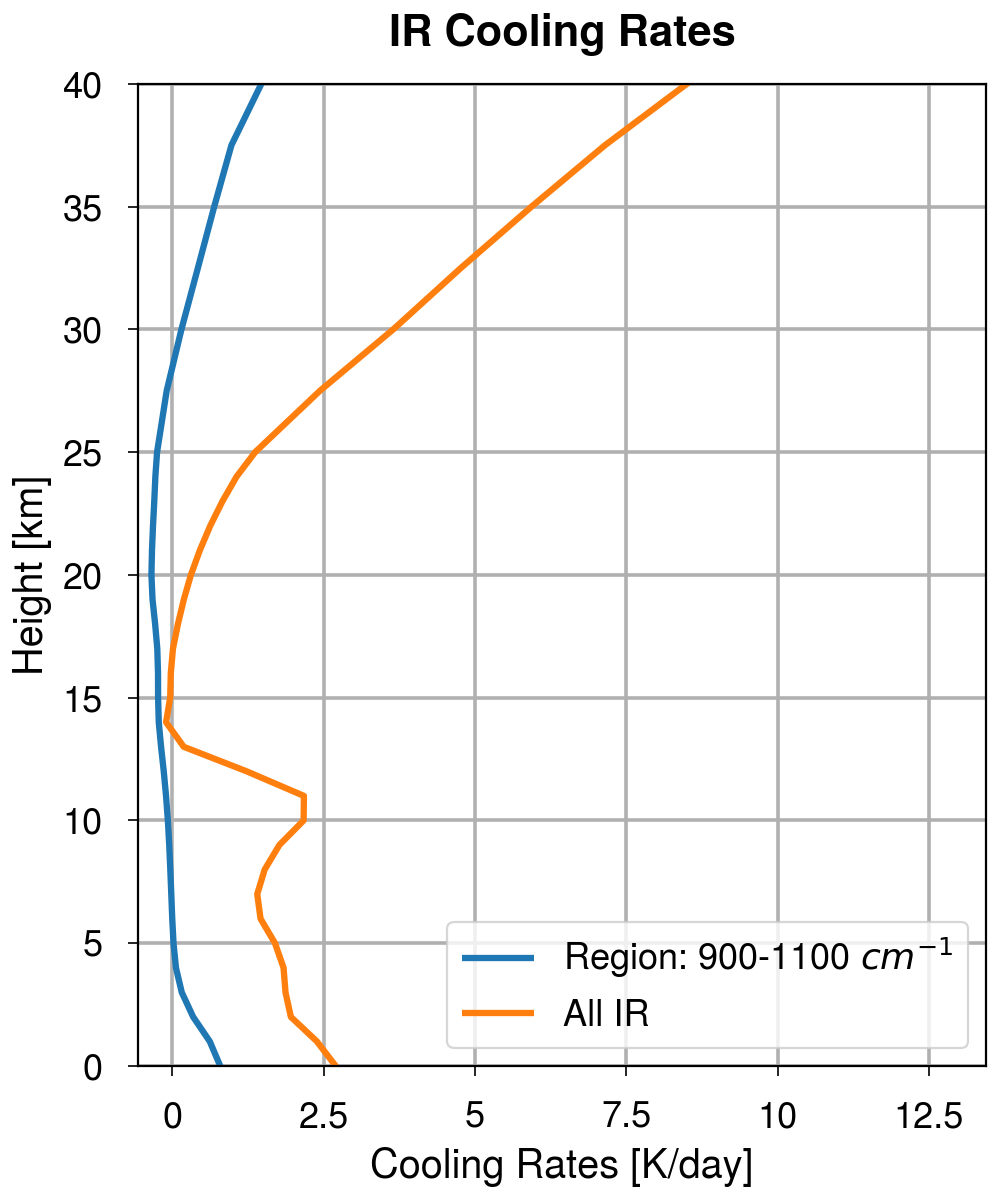

In [103]:
# Calculate heating rate and plot it
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(5,6))
fig.format(suptitle=f"IR Cooling Rates")
axs.plot(band_heating, z/1000., label=f"Region: {fmin}-{fmax} ${{cm}}^{{-1}}$")
axs.plot(total_heating.squeeze(), z/1000.,label="All IR")
axs.format(grid=True, ylabel="Height [km]", xlabel="Cooling Rates [K/day]",
          ylim=(0,40))
axs.legend(loc=0, ncols=1)
pplt.show()